In [1]:
import os

import gymnasium as gym
import mediapy as media
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

import wandb
from legato.nets import *
from legato.sampler import *

In [2]:
# Set mujoco to use EGL
os.environ["MUJOCO_GL"] = "egl"

In [3]:
# Download files from a past wandb run
run_id = "mishmish66/Legato/f9etzn17"
for name in [
    "state_encoder.pt",
    "action_encoder.pt",
    "transition_model.pt",
    "state_decoder.pt",
    "action_decoder.pt",
    "indices.npz",
]:
    wandb.restore(
        f"trained_net_params/{name}",
        run_path=run_id,
        replace=True,
        root="../",
    )

In [4]:
# Load models
state_encoder = torch.load('../trained_net_params/state_encoder.pt')
action_encoder = torch.load('../trained_net_params/action_encoder.pt')
transiton_model = torch.load('../trained_net_params/transition_model.pt')
state_decoder = torch.load('../trained_net_params/state_decoder.pt')
action_decoder = torch.load('../trained_net_params/action_decoder.pt')

In [5]:
action_space_size = 1.0

In [115]:
# Now let's optimize a trajectory
def custom(x, y):
    reg = 0.1
    norm = torch.norm(x - y, p=1, dim=-1)
    norm_sq = norm * norm
    return torch.log(norm+1.0) # torch.log(norm_sq + reg) + norm_sq - np.log(reg)


actor = ActorPolicy(
    2,
    action_space_size,
    state_encoder,
    transiton_model,
    state_decoder,
    action_decoder,
    optim_factory=torch.optim.SGD,
    # optim_factory=torch.optim.AdamW,
    # loss_func=custom,
    loss_func=torch.nn.L1Loss(reduction="none"),
    lr=4.0,
    decay=1.0,
    horizon=1024,
    iters=64,
    # tail_states=4,
    discount=0.99,
    temperature=0.0,
    samples=1,
    condensation_weight=100.0,
).cuda()

# actor = torch.compile(actor)
episode_len = 1024

parallel_env_count = 32
# Make parallel env
envs = gym.vector.make(
    "PointMaze_Medium-v3",
    num_envs=parallel_env_count,
    asynchronous=False,
    render_mode="rgb_array",
    continuing_task=True,
    max_episode_steps=episode_len,
    reset_target=True,
)

obses, infos = envs.reset()
states = torch.tensor(obses["observation"], dtype=torch.float32, device="cuda")

latent_action_plan = None

initial_state = states

traj_actions = []
traj_states = [initial_state]

frame_stacks = [[frame] for frame in envs.call("render")]

skips = 4

goals = []
imagined_states = []
successes = []

loss_curves = []
for i in tqdm(range(episode_len), disable=True):

    if i % skips == 0:
        target_states = torch.zeros(
            (parallel_env_count, 4), dtype=torch.float32, device="cuda"
        )
        desired_goals = torch.tensor(
            obses["desired_goal"], dtype=torch.float32, device="cuda"
        )
        target_states[:, :2] = desired_goals

        horizon_len = min(256, episode_len - i)
        horizons = torch.ones(parallel_env_count, device="cuda") * horizon_len
        next_actions, latent_action_plan, imagined, loss_curve = actor(
            # states, target_states, horizons, None, return_curve=True
            states, target_states, horizons, latent_action_plan, return_curve=True
        )

        imagined_states.append(imagined[..., :skips, :])
        loss_curves.append(loss_curve)

    else:
        next_latent_act = latent_action_plan[..., 0, :]
        latent_action_plan = latent_action_plan[..., 1:, :]

        latent_states = state_encoder(states)
        next_actions = action_decoder((next_latent_act, latent_states)).detach()

    obses, rew, term, trunc, info = envs.step(next_actions.cpu().numpy())
    
    states = torch.tensor(obses["observation"], dtype=torch.float32, device="cuda")
    
    goals.append(desired_goals)
    successes.append(info["success"])
    traj_actions.append(next_actions)
    traj_states.append(
        torch.tensor(obses["observation"], device="cuda", dtype=torch.float32)
    )

    for frame_stack, frame in zip(frame_stacks, envs.call("render")):
        frame_stack.append(frame)

    if i % skips in [skips - 1, 0, 1]:
        print(
            f"Iteration {i}, {i % skips} after skip, action: {next_actions[0].cpu().numpy()}"
        )

traj_actions = torch.stack(traj_actions, dim=1)
traj_states = torch.stack(traj_states, dim=1)

/home/mishmish/Documents/venvs/legato_simple/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


Loss: 0.12525391578674316
Undiscounted losses: 1.61558198928833
Action violations: 4.194153007119894e-07
Iteration 0, 0 after skip, action: [-0.06792833  0.5927835 ]
Iteration 1, 1 after skip, action: [0.32657796 0.54346275]
Iteration 3, 3 after skip, action: [0.3102047  0.54281396]
Loss: 0.11755058914422989
Undiscounted losses: 1.516216516494751
Action violations: 4.100729711353779e-07
Iteration 4, 0 after skip, action: [ 0.3407111  -0.02162176]
Iteration 5, 1 after skip, action: [0.20948783 0.40787563]
Iteration 7, 3 after skip, action: [0.3694437 0.5467698]
Loss: 0.1115092933177948
Undiscounted losses: 1.4375224113464355
Action violations: 9.319192031398416e-07
Iteration 8, 0 after skip, action: [0.26554692 0.30770847]
Iteration 9, 1 after skip, action: [0.25980562 0.48149255]
Iteration 11, 3 after skip, action: [-0.4091733   0.60468376]
Loss: 0.10695601999759674
Undiscounted losses: 1.3794108629226685
Action violations: 4.3190084397792816e-07
Iteration 12, 0 after skip, action: [0.

<Axes: ylabel='Count'>

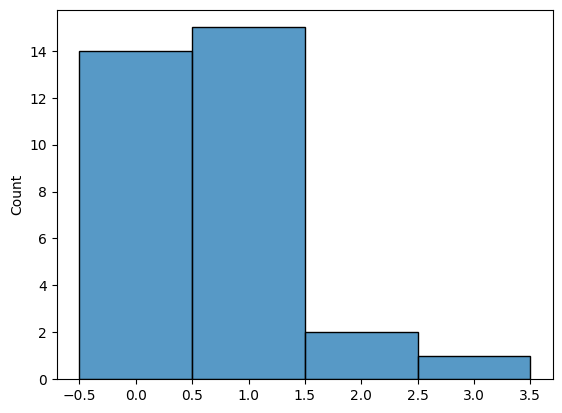

In [116]:
# Scatterplot of success count
total_success_per_env = np.stack(successes, axis=1).sum(axis=1)
sns.histplot(total_success_per_env.astype(np.int32), discrete=True)

<Axes: >

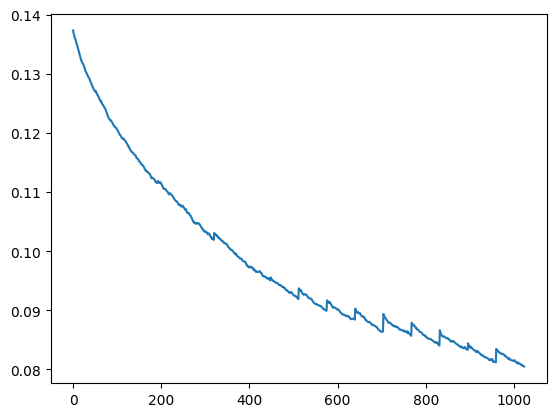

In [117]:
curve = np.concatenate(loss_curves)[0:1024]
# Plot the loss curve with i as the x axis
sns.lineplot(x=range(len(curve)), y=curve, estimator=None)

<Axes: xlabel='x', ylabel='y'>

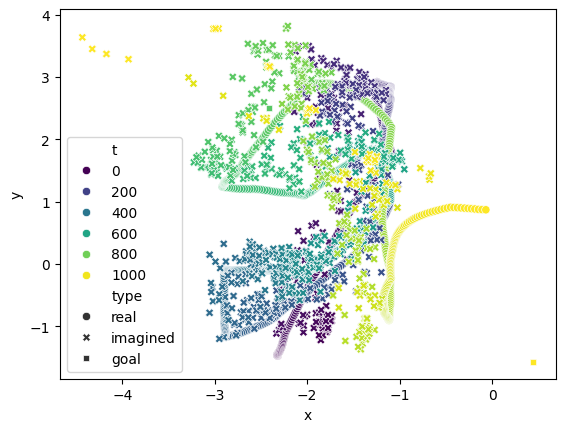

In [114]:
# Plot imagined trajectories vs real

i = 2

all_imagined = torch.cat(imagined_states, dim=-2)
all_goals = torch.stack(goals, dim=-2)
imagined_len = all_imagined.shape[-2]
real_states = traj_states[i]

# Plot the x and y positions of the imagined and real trajectories with color representing time
df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": real_states[:imagined_len, 0].cpu().numpy(),
                "y": real_states[:imagined_len, 1].cpu().numpy(),
                "t": np.arange(imagined_len),
                "type": "real",
            }
        ),
        pd.DataFrame(
            {
                "x": all_imagined[i, :, 0].cpu().numpy(),
                "y": all_imagined[i, :, 1].cpu().numpy(),
                "t": np.arange(imagined_len),
                "type": "imagined",
            }
        ),
        pd.DataFrame(
            {
                "x": all_goals[i, :, 0].cpu().numpy(),
                "y": all_goals[i, :, 1].cpu().numpy(),
                "t": np.arange(imagined_len),
                "type": "goal",
            }
        ),
    ]
)

sns.scatterplot(data=df, x="x", y="y", hue="t", style="type", palette="viridis")

In [109]:
videos = np.stack([frames[::8] for frames in frame_stacks], axis=0)

In [110]:
# Show the video
media.show_videos(videos, fps=30, columns=1)

In [125]:
traj_states = traj_states.to(torch.float32)

In [126]:
latent_traj_states = state_encoder(traj_states)
latent_traj_actions = action_encoder((traj_actions, traj_states[..., :-1, :]))
latent_initial_state = state_encoder(initial_state)

predicted_fut_latent_states, mask = transiton_model(
    latent_initial_state, latent_traj_actions, return_mask=True
)
predicted_fut_states = state_decoder(predicted_fut_latent_states)
actual_fut_states = traj_states[..., 1:, :]
latent_traj_states = state_encoder(traj_states)
actual_fut_latent_states = state_encoder(actual_fut_states)

In [130]:
pos_l2s = torch.norm(
    predicted_fut_states[..., :2] - actual_fut_states[..., :2], dim=-1, p=2
)
ravg_num = 3
pos_l2s_stack = repeat(pos_l2s, "... t -> ... tp t", tp=pos_l2s.shape[-1])
smooth_pos_l2s = torch.tril(torch.triu(pos_l2s_stack, -ravg_num), ravg_num).mean(-1)

df = pd.DataFrame.from_records(
    [
        [step, pos_l2.item(), vel_l2.item(), env]
        for env, (pos_l2s, vel_l2s) in enumerate(
            zip(
                smooth_pos_l2s,
                torch.norm(
                    predicted_fut_states[..., 2:] - actual_fut_states[..., 2:],
                    dim=-1,
                    p=2,
                ),
            )
        )
        for step, (pos_l2, vel_l2) in enumerate(zip(pos_l2s, vel_l2s))
    ],
    columns=["step", "pos_l2", "vel_l2", "env"],
)

<Axes: xlabel='step', ylabel='pos_l2'>

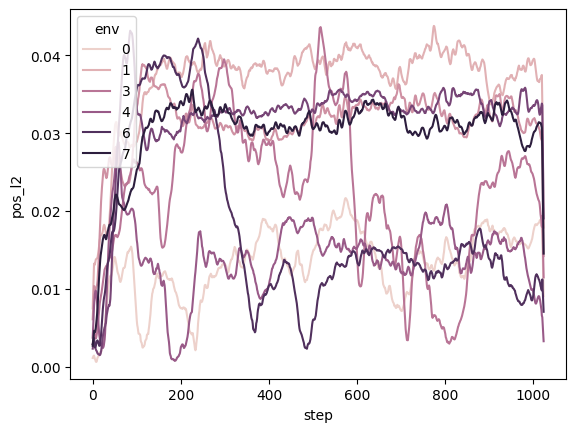

In [132]:
sns.lineplot(df, x="step", y="pos_l2", hue="env", estimator="rolling", errorbar=None)

In [129]:
actual_fut_latent_states = state_encoder(actual_fut_states)

In [37]:
traj_actions

tensor([[[-19.4858,   7.9778],
         [-10.2255,  20.5812],
         [  8.6241,  17.8359],
         ...,
         [  0.4080,   5.7599],
         [ -2.2726,   7.4269],
         [ -0.8104, -17.5956]],

        [[  0.7271,   5.0356],
         [ -2.9209,   0.5106],
         [ -1.1688,  -5.2039],
         ...,
         [  0.9018,   5.7926],
         [  8.3837,   2.7548],
         [ 38.5721, -11.3238]],

        [[ 24.6632, -10.0322],
         [ 27.0246, -18.3869],
         [ -7.6568,   1.1020],
         ...,
         [-14.9291,   6.2791],
         [  8.0676,  10.8957],
         [ 14.5055, -13.8511]],

        ...,

        [[ -6.6775,  -9.7980],
         [-32.5140, -15.3525],
         [ -4.3558, -16.9719],
         ...,
         [ -4.0442,  -7.8724],
         [ -2.3832,  15.1887],
         [  6.1405, -26.8620]],

        [[-17.1863,   2.2624],
         [ -3.7328,  -0.0390],
         [-14.9329,   1.4140],
         ...,
         [  3.7436, -16.9604],
         [ -5.7048,   0.8881],
         

In [38]:
traj_states

tensor([[[-2.3528e+00, -1.6561e+00,  0.0000e+00,  0.0000e+00],
         [-2.3552e+00, -1.6537e+00, -2.3816e-01,  2.3816e-01],
         [-2.3600e+00, -1.6490e+00, -4.7576e-01,  4.7576e-01],
         ...,
         [-2.3475e+00, -1.4590e+00,  1.0228e+00, -3.1603e+00],
         [-2.3397e+00, -1.4882e+00,  7.8215e-01, -2.9147e+00],
         [-2.3061e+00, -5.6721e-01,  0.0000e+00,  0.0000e+00]],

        [[ 2.6304e+00, -1.6432e+00,  0.0000e+00,  0.0000e+00],
         [ 2.6321e+00, -1.6408e+00,  1.7317e-01,  2.3816e-01],
         [ 2.6315e+00, -1.6372e+00, -6.5408e-02,  3.5919e-01],
         ...,
         [ 1.1249e+00, -2.8724e+00,  4.8659e-01,  7.1158e-01],
         [ 1.1322e+00, -2.8629e+00,  7.2359e-01,  9.4805e-01],
         [-7.1802e-01,  3.8412e-01,  0.0000e+00,  0.0000e+00]],

        [[ 1.5945e+00, -4.1595e-01,  0.0000e+00,  0.0000e+00],
         [ 1.5969e+00, -4.1833e-01,  2.3816e-01, -2.3816e-01],
         [ 1.6017e+00, -4.2309e-01,  4.7576e-01, -4.7576e-01],
         ...,
         

In [39]:
reconstructed_traj_actions = action_decoder(
    (latent_traj_actions, latent_traj_states[..., :-1, :])
)

In [40]:
reconstructed_traj_actions

tensor([[[ -8.4823,   5.8519],
         [ -9.7166,   9.9460],
         [  8.1545,   5.9076],
         ...,
         [  0.7269,   4.1846],
         [ -0.9057,   4.8503],
         [  0.6510,  -8.9483]],

        [[  0.6546,   4.3937],
         [ -3.5413,   0.6575],
         [ -0.7474,  -3.3008],
         ...,
         [  0.6874,   3.9347],
         [  4.0721,   4.4420],
         [  9.6461, -12.2593]],

        [[  5.7644, -12.4125],
         [  8.0572, -20.7546],
         [ -4.1760,   0.5295],
         ...,
         [ -6.5863,   5.2126],
         [  7.1682,   5.7940],
         [  7.3088, -12.5797]],

        ...,

        [[ -6.3879,  -6.4226],
         [-21.6892, -17.0599],
         [ -2.2152,  -9.3608],
         ...,
         [ -2.2982,  -6.1342],
         [ -2.2289,   5.5065],
         [  7.2451, -15.4946]],

        [[ -8.6667,   0.9512],
         [ -3.8460,   0.4101],
         [ -7.9839,   0.7766],
         ...,
         [  4.4481,  -9.3875],
         [ -4.7391,   0.7757],
         

In [41]:
predicted_fut_latent_states

tensor([[[-1.6523e-01,  2.0978e-01,  2.8473e-01, -4.6601e-02],
         [-2.0386e-01,  2.1504e-01,  2.6924e-01, -3.6529e-02],
         [ 3.0638e+00, -2.7762e-01,  9.6486e+00, -6.1792e-01],
         ...,
         [ 5.7609e+00, -9.4505e-01,  1.5618e+01,  9.6470e-01],
         [-7.4451e-02,  2.8917e-01,  8.9935e-01, -2.0088e-01],
         [-2.4404e-02,  3.0181e-01, -1.3305e-01, -1.7360e-01]],

        [[ 3.1763e-01,  7.9324e-01,  2.4427e+00,  8.9647e-02],
         [ 1.1843e-01,  1.1935e-01,  5.5498e-02, -1.8933e-01],
         [ 1.4243e-01,  1.4352e-02, -6.5916e-02, -8.3735e-02],
         ...,
         [-1.5028e-01,  7.6931e-01,  3.1762e+00, -1.2787e-01],
         [-2.7487e-01,  5.7835e-01,  1.8935e+00, -1.1114e+00],
         [ 1.6678e+00,  3.5334e+00,  7.2332e-03, -6.8010e-01]],

        [[ 2.2401e+00,  2.4690e+00,  4.7776e-01,  1.9729e-02],
         [ 1.3843e+00,  1.4403e+00,  3.7895e-01,  2.1303e-01],
         [-1.3080e-01,  1.5317e-01,  1.4400e-01, -7.7144e-02],
         ...,
         

In [42]:
actual_fut_latent_states

tensor([[[-0.0113,  0.0285,  0.0840,  0.0047],
         [-0.0254,  0.0273,  0.0836, -0.0023],
         [-0.0332,  0.0284,  0.0826,  0.0039],
         ...,
         [ 0.2569,  0.0262,  0.0372, -0.0104],
         [ 0.0418,  0.0214,  0.0283, -0.0217],
         [ 0.0142,  0.0282,  0.0927,  0.0170]],

        [[-0.0178,  0.0211,  0.0707, -0.1079],
         [-0.0241,  0.0192,  0.0756, -0.1057],
         [-0.0159,  0.0215,  0.0772, -0.1024],
         ...,
         [-0.0249,  0.0457,  0.0725, -0.0792],
         [-0.0346,  0.0490,  0.0683, -0.0815],
         [-0.0075, -0.0214,  0.0773, -0.0461]],

        [[-0.0041, -0.0050,  0.0708, -0.0800],
         [ 0.0030, -0.0084,  0.0672, -0.0814],
         [-0.0041, -0.0047,  0.0702, -0.0795],
         ...,
         [-0.0142,  0.0305,  0.0141, -0.0275],
         [-0.0127,  0.0316,  0.0168, -0.0266],
         [-0.0127, -0.0188,  0.0754, -0.0927]],

        ...,

        [[-0.0049, -0.0227,  0.0852,  0.0033],
         [-0.0050, -0.0143,  0.0843, -0.0028]

In [43]:
predicted_fut_states

tensor([[[ 0.6838, -2.4025,  1.6843,  1.4038],
         [ 0.7170, -2.4663,  1.6890,  1.4987],
         [ 1.3457,  2.7106,  3.3357, -3.2189],
         ...,
         [-1.8896,  4.2592,  4.3585, -1.9385],
         [ 2.8458, -1.5769,  2.4416,  0.5844],
         [ 2.8086, -3.1542,  2.6979,  0.2394]],

        [[-0.0978, -0.8496,  4.2154, -0.5679],
         [ 2.2037, -2.6750,  1.2914, -0.4113],
         [ 1.3692, -1.1550,  1.6202, -2.9330],
         ...,
         [ 2.9191, -0.7483,  4.2902,  0.9212],
         [ 1.4259,  1.0558,  3.7647,  1.8306],
         [ 0.9674,  0.3132,  5.2962, -3.6546]],

        [[-0.2876, -1.0799,  5.1224, -3.4446],
         [-1.2964, -0.0170,  6.5242, -4.0611],
         [ 1.7924, -2.3073,  1.5659,  1.9810],
         ...,
         [ 2.4452, -2.5464,  1.7014,  1.4063],
         [ 1.4673,  0.2060,  4.5631,  0.6338],
         [-1.0021, -1.4941,  4.1517, -2.2241]],

        ...,

        [[ 2.6892, -2.8759,  1.6082,  1.6924],
         [ 2.5355, -2.6937,  1.2214,  2.3863]

In [44]:
actual_fut_states

tensor([[[-2.3552e+00, -1.6537e+00, -2.3816e-01,  2.3816e-01],
         [-2.3600e+00, -1.6490e+00, -4.7576e-01,  4.7576e-01],
         [-2.3623e+00, -1.6419e+00, -2.3646e-01,  7.1279e-01],
         ...,
         [-2.3475e+00, -1.4590e+00,  1.0228e+00, -3.1603e+00],
         [-2.3397e+00, -1.4882e+00,  7.8215e-01, -2.9147e+00],
         [-2.3061e+00, -5.6721e-01,  0.0000e+00,  0.0000e+00]],

        [[ 2.6321e+00, -1.6408e+00,  1.7317e-01,  2.3816e-01],
         [ 2.6315e+00, -1.6372e+00, -6.5408e-02,  3.5919e-01],
         [ 2.6284e+00, -1.6360e+00, -3.0342e-01,  1.2017e-01],
         ...,
         [ 1.1249e+00, -2.8724e+00,  4.8659e-01,  7.1158e-01],
         [ 1.1322e+00, -2.8629e+00,  7.2359e-01,  9.4805e-01],
         [-7.1802e-01,  3.8412e-01,  0.0000e+00,  0.0000e+00]],

        [[ 1.5969e+00, -4.1833e-01,  2.3816e-01, -2.3816e-01],
         [ 1.6017e+00, -4.2309e-01,  4.7576e-01, -4.7576e-01],
         [ 1.6040e+00, -4.2545e-01,  2.3646e-01, -2.3646e-01],
         ...,
         

In [45]:
latent_state_sampler = PBallSampler(4, 1, 2.0, device="cuda")
latent_action_sampler = PBallSampler(2, 1, 1.0, device="cuda")
latent_action_state_sampler = lambda n: (
    latent_action_sampler(n),
    latent_state_sampler(n),
)

In [46]:
action_samples = action_decoder(latent_action_state_sampler(4096))

In [47]:
action_samples

tensor([[-0.5052, -0.6258],
        [ 0.4603, -0.9277],
        [-0.8998,  0.0505],
        ...,
        [-0.4713, -0.4522],
        [ 0.9070, -0.2668],
        [-0.3767, -0.9912]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [48]:
actions

NameError: name 'actions' is not defined